First we build the Hamiltonian we want in Qiskit

In [1]:
from qiskit.circuit import QuantumCircuit, Parameter
from qiskit.circuit.library import PauliEvolutionGate
from qiskit.quantum_info import SparsePauliOp
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit.transpiler import CouplingMap
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit.synthesis import LieTrotter

from qiskit_ibm_runtime.options import EstimatorOptions, DynamicalDecouplingOptions
from qiskit_ibm_runtime import EstimatorV2, Batch, SamplerV2
from qiskit_aer import AerSimulator
from qiskit_ibm_runtime.fake_provider import FakeManilaV2
from qiskit_addon_cutting import partition_problem, generate_cutting_experiments, reconstruct_expectation_values

import numpy as np
import matplotlib.pyplot as plt
import json


In [2]:
def build_hamiltonian(num_spins, coupling_map, anisotropy = 1, h = 1):

    edge_list = coupling_map.get_edges()
    hamlist = []

    for edge in edge_list:
        hamlist.append(('XX', edge, anisotropy))
    
    for qubit in coupling_map.physical_qubits:
        hamlist.append(('Z', [qubit], h))

    hamiltonian = SparsePauliOp.from_sparse_list(hamlist, num_qubits= num_spins)
    return hamiltonian
 

In [3]:
num_spins = 5  # Number of qubits per ring
num_rings = 2  # Total number of rings
# Generate edges
edges = [
    (ring * num_spins + i, ring * num_spins + (i + 1) % num_spins)
    for ring in range(num_rings)
    for i in range(num_spins)
]
edges.append((0, 2*num_spins-1))


coupling_map = CouplingMap(edges)
#coupling_map.draw()

In [6]:
# Hamiltonian and evolution parameters
num_qubits = num_rings * num_spins
anisotropy = 1.
h = 1.
dt = Parameter('δt')
trotter_reps = 1
dt = 0.1

H = build_hamiltonian(num_qubits, coupling_map, anisotropy, h)

trotterizator = LieTrotter(reps = trotter_reps, insert_barriers=False)
U = PauliEvolutionGate(operator = H, time = dt)
evolutionQC = trotterizator.synthesize(U)

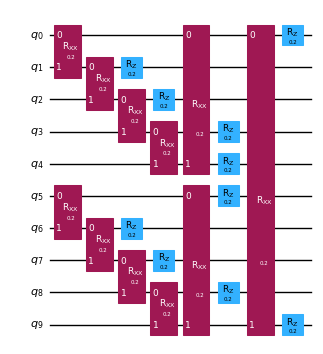

In [7]:
evolutionQC.draw('mpl', scale = 0.5)

In [13]:
z_list = [('Z', [i], 1.) for i in range(num_qubits)]
z_observables = SparsePauliOp.from_sparse_list(z_list, num_qubits = num_qubits)
print(z_observables)

SparsePauliOp(['IIIIIIIIIZ', 'IIIIIIIIZI', 'IIIIIIIZII', 'IIIIIIZIII', 'IIIIIZIIII', 'IIIIZIIIII', 'IIIZIIIIII', 'IIZIIIIIII', 'IZIIIIIIII', 'ZIIIIIIIII'],
              coeffs=[1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j,
 1.+0.j])


In [15]:
cutting_labels = num_spins * 'A' + num_spins * 'B'
partitioned_problem = partition_problem(circuit = evolutionQC, partition_labels = cutting_labels, observables = z_observables.paulis)
subcircuits = partitioned_problem.subcircuits
subobservables = partitioned_problem.subobservables
bases = partitioned_problem.bases

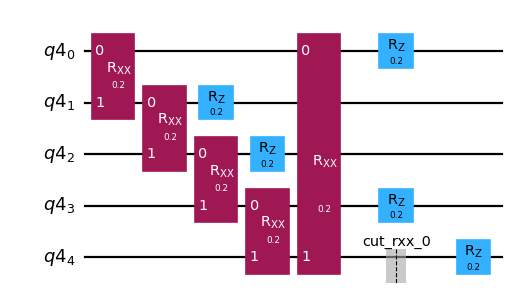

In [17]:
subcircuits["A"].draw("mpl", scale = 0.8, fold = False)
subcircuits["B"].draw("mpl", scale = 0.8, fold = False)

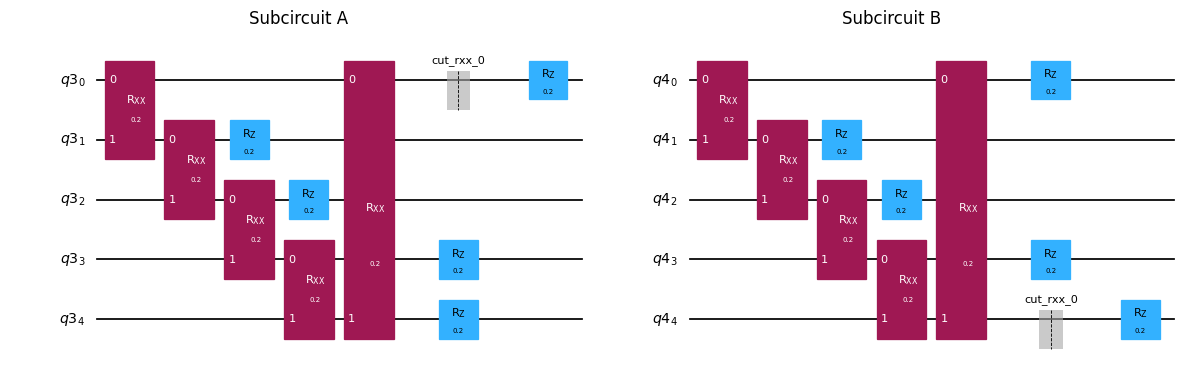

In [18]:
import matplotlib.pyplot as plt

# Create a figure with 1 row and 2 columns of subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Draw the first subcircuit on the first axis
subcircuits["A"].draw("mpl", scale=0.8, fold=False, ax=axs[0])
axs[0].set_title("Subcircuit A")

# Draw the second subcircuit on the second axis
subcircuits["B"].draw("mpl", scale=0.8, fold=False, ax=axs[1])
axs[1].set_title("Subcircuit B")

# Adjust layout for better spacing
plt.tight_layout()

# Display both plots in the same cell
plt.show()
